In [1]:
# API key ID: otlwwfxero72fkms03hi49x2
# API key secret: 5qbnpzqphl1y8bz6eggxraxlzlnbnhso49bro4925r1rpxj6sn
# app token: 8y23ArYxg4pcvOMgWzMFSC0nB
# secret app token: pZgwEL4lKm2r1s868Saz3EJ1ebpTKy-FzglU

# crime data docs: https://dev.socrata.com/foundry/data.cityofchicago.org/9hwr-2zxp

# make sure to install these packages before running:
!pip install pandas
!pip install sodapy
!pip install category_encoders

In [2]:
import pandas as pd
import sodapy
from sodapy import Socrata
import statistics
pd.set_option('display.max_columns', 500)

In [3]:
# crime_url = "https://data.cityofchicago.org/resource/9hwr-2zxp.json"


app_token = "8y23ArYxg4pcvOMgWzMFSC0nB"

# Example authenticated client (needed for non-public datasets):
client = Socrata("data.cityofchicago.org",
                 app_token, 
                 username="ch35@illinois.edu",
                 password="68M8rz3vF!StBjD")


# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("9hwr-2zxp", limit = 250000)

# Convert to pandas DataFrame
crime_df = pd.DataFrame.from_records(results)

print(crime_df.shape)

(212116, 22)


# Logistic Regression

In [4]:
crime_df.head()

,date,location,district,block,y_coordinate,latitude,description,location_description,updated_on,community_area,iucr,x_coordinate,ward,case_number,year,domestic,fbi_code,longitude,beat,primary_type,arrest,id
0,2022-11-25T23:59:00.000,"{'latitude': '41.760940791', 'human_address': ...",007,073XX S MORGAN ST,1856220,41.760940791,ATTEMPT - AUTOMOBILE,STREET,2022-12-02T15:47:13.000,68,0920,1170913,17,JF487931,2022,False,07,-87.64915621,0733,MOTOR VEHICLE THEFT,False,12903749
1,2022-11-25T23:59:00.000,"{'latitude': '41.796804813', 'human_address': ...",002,008XX E 54TH ST,1869386,41.796804813,THEFT / RECOVERY - AUTOMOBILE,STREET,2022-12-02T15:47:13.000,41,0930,1182671,5,JF489428,2022,False,07,-87.605654453,0233,MOTOR VEHICLE THEFT,False,12905081
2,2022-11-25T23:55:00.000,"{'latitude': '41.830812527', 'human_address': ...",009,034XX S CALIFORNIA AVE,1881585,41.830812527,BOMB THREAT,GAS STATION,2022-12-02T15:47:13.000,58,2850,1158263,12,JF487744,2022,False,24,-87.694828962,0911,PUBLIC PEACE VIOLATION,False,12903564
3,2022-11-25T23:55:00.000,"{'latitude': '41.891243826', 'human_address': ...",018,005XX N COLUMBUS DR,1903766,41.891243826,TO PROPERTY,PARKING LOT / GARAGE (NON RESIDENTIAL),2022-12-02T15:47:13.000,8,1310,1178412,42,JF487757,2022,False,14,-87.620225683,1834,CRIMINAL DAMAGE,False,12903570
4,2022-11-25T23:53:00.000,"{'latitude': '41.923198512', 'human_address': ...",025,023XX N SPRINGFIELD AVE,1915192,41.923198512,FROM BUILDING,APARTMENT,2022-12-02T15:47:13.000,22,0890,1149996,35,JF489676,2022,False,06,-87.724286303,2525,THEFT,False,12905193


In [5]:
#creating variable for month
month = [i[0:7] for i in crime_df.date]

In [6]:
#adding to data frame
crime_df["month"] = month

In [7]:
#dropping irrelevant variables
crime_df_clean = crime_df.drop(["date", "location", "block", "updated_on", "case_number", "year", "id"], axis = 1)
crime_df_clean.head()

,district,y_coordinate,latitude,description,location_description,community_area,iucr,x_coordinate,ward,domestic,fbi_code,longitude,beat,primary_type,arrest,month
0,007,1856220,41.760940791,ATTEMPT - AUTOMOBILE,STREET,68,0920,1170913,17,False,07,-87.64915621,0733,MOTOR VEHICLE THEFT,False,2022-11
1,002,1869386,41.796804813,THEFT / RECOVERY - AUTOMOBILE,STREET,41,0930,1182671,5,False,07,-87.605654453,0233,MOTOR VEHICLE THEFT,False,2022-11
2,009,1881585,41.830812527,BOMB THREAT,GAS STATION,58,2850,1158263,12,False,24,-87.694828962,0911,PUBLIC PEACE VIOLATION,False,2022-11
3,018,1903766,41.891243826,TO PROPERTY,PARKING LOT / GARAGE (NON RESIDENTIAL),8,1310,1178412,42,False,14,-87.620225683,1834,CRIMINAL DAMAGE,False,2022-11
4,025,1915192,41.923198512,FROM BUILDING,APARTMENT,22,0890,1149996,35,False,06,-87.724286303,2525,THEFT,False,2022-11


## Removing Categorical Variables with High Cardinality (50+ Levels)

In [8]:
crime_df_clean.dtypes

district                object
y_coordinate            object
latitude                object
description             object
location_description    object
community_area          object
iucr                    object
x_coordinate            object
ward                    object
domestic                  bool
fbi_code                object
longitude               object
beat                    object
primary_type            object
arrest                    bool
month                   object
dtype: object

In [9]:
#converting variables to numeric
num_vars = ["y_coordinate", "x_coordinate", "latitude", "longitude"]
for i in num_vars:
    crime_df_clean[i] = crime_df_clean[i].astype("float")
crime_df_clean.dtypes

district                 object
y_coordinate            float64
latitude                float64
description              object
location_description     object
community_area           object
iucr                     object
x_coordinate            float64
ward                     object
domestic                   bool
fbi_code                 object
longitude               float64
beat                     object
primary_type             object
arrest                     bool
month                    object
dtype: object

In [10]:
#converting boolean variables to binary categorical variables
crime_df_clean["domestic"] = crime_df_clean["domestic"].astype(int)
crime_df_clean["arrest"] = crime_df_clean["arrest"].astype(int)
crime_df_clean.dtypes

district                 object
y_coordinate            float64
latitude                float64
description              object
location_description     object
community_area           object
iucr                     object
x_coordinate            float64
ward                     object
domestic                  int64
fbi_code                 object
longitude               float64
beat                     object
primary_type             object
arrest                    int64
month                    object
dtype: object

In [11]:
crime_df_clean["arrest"].dtypes == "O"

False

In [12]:
#storing list of cateogorical variables with high cardinality
high_card = [var for var in crime_df_clean.columns if len(crime_df_clean[var].value_counts()) >= 50 and crime_df_clean[var].dtypes == "O"]
high_card

['description',
 'location_description',
 'community_area',
 'iucr',
 'ward',
 'beat']

In [13]:
#dropping from set
crime_df_new = crime_df_clean.drop(high_card, axis = 1)
crime_df_new.head()

,district,y_coordinate,latitude,x_coordinate,domestic,fbi_code,longitude,primary_type,arrest,month
0,007,1856220.0,41.760941,1170913.0,0,07,-87.649156,MOTOR VEHICLE THEFT,0,2022-11
1,002,1869386.0,41.796805,1182671.0,0,07,-87.605654,MOTOR VEHICLE THEFT,0,2022-11
2,009,1881585.0,41.830813,1158263.0,0,24,-87.694829,PUBLIC PEACE VIOLATION,0,2022-11
3,018,1903766.0,41.891244,1178412.0,0,14,-87.620226,CRIMINAL DAMAGE,0,2022-11
4,025,1915192.0,41.923199,1149996.0,0,06,-87.724286,THEFT,0,2022-11


## Binning Categorical Variables
#### Goal is to group levels together if they share a similar target rate to establish bin credibility (at least 1% of observations in each bin)

In [14]:
cat_vars = [var for var in crime_df_new.columns if crime_df_new[var].dtypes == "O"]
cat_vars

['district', 'fbi_code', 'primary_type', 'month']

In [15]:
#district
pd.DataFrame({"District": crime_df_new["district"].value_counts().index, "Target Rate": [round(statistics.mean(crime_df_new["arrest"].loc[crime_df_new["district"] == i]), 3) for i in crime_df_new["district"].value_counts().index], "Proportion": [round(crime_df_new.loc[crime_df_new["district"] == i].shape[0] / crime_df_new.shape[0], 3) for i in crime_df_new["district"].value_counts().index]}).sort_values(by = "Target Rate")
                                                                                                                                                                                                                               

,District,Target Rate,Proportion
22,16,0.000,0.000
7,019,0.072,0.051
2,012,0.082,0.060
10,002,0.086,0.049
21,020,0.088,0.021
1,008,0.091,0.062
8,003,0.091,0.050
3,004,0.092,0.059
19,022,0.097,0.032
17,024,0.098,0.036


##### Decision: 16 + 019, 011 + 031, all others can remain on their own

In [16]:
#FBI Code
pd.DataFrame({"FBI Code": crime_df_new["fbi_code"].value_counts().index, "Target Rate": [round(statistics.mean(crime_df_new["arrest"].loc[crime_df_new["fbi_code"] == i]), 3) for i in crime_df_new["fbi_code"].value_counts().index], "Proportion": [round(crime_df_new.loc[crime_df_new["fbi_code"] == i].shape[0] / crime_df_new.shape[0], 3) for i in crime_df_new["fbi_code"].value_counts().index]}).sort_values(by = "Target Rate")
                                                                                                                                                                                                                               

,FBI Code,Target Rate,Proportion
23,12,0.000,0.000
13,10,0.007,0.010
6,11,0.013,0.053
3,07,0.025,0.086
14,02,0.026,0.007
2,14,0.031,0.116
0,06,0.035,0.232
10,05,0.038,0.032
8,03,0.047,0.037
15,17,0.054,0.007


##### Decision: Variable incredibly similar to the variable below, we'll drop this one

In [17]:
crime_df_new = crime_df_new.drop(["fbi_code"], axis = 1)
crime_df_new.head()

,district,y_coordinate,latitude,x_coordinate,domestic,longitude,primary_type,arrest,month
0,007,1856220.0,41.760941,1170913.0,0,-87.649156,MOTOR VEHICLE THEFT,0,2022-11
1,002,1869386.0,41.796805,1182671.0,0,-87.605654,MOTOR VEHICLE THEFT,0,2022-11
2,009,1881585.0,41.830813,1158263.0,0,-87.694829,PUBLIC PEACE VIOLATION,0,2022-11
3,018,1903766.0,41.891244,1178412.0,0,-87.620226,CRIMINAL DAMAGE,0,2022-11
4,025,1915192.0,41.923199,1149996.0,0,-87.724286,THEFT,0,2022-11


In [18]:
#Primary Type
pd.DataFrame({"Primary Type": crime_df_new["primary_type"].value_counts().index, "Target Rate": [round(statistics.mean(crime_df_new["arrest"].loc[crime_df_new["primary_type"] == i]), 3) for i in crime_df_new["primary_type"].value_counts().index], "Proportion": [round(crime_df_new.loc[crime_df_new["primary_type"] == i].shape[0] / crime_df_new.shape[0], 3) for i in crime_df_new["primary_type"].value_counts().index]}).sort_values(by = "Target Rate")
                                                                                                                                                                                                                               

,Primary Type,Target Rate,Proportion
26,HUMAN TRAFFICKING,0.000,0.000
23,INTIMIDATION,0.007,0.001
5,DECEPTIVE PRACTICE,0.015,0.063
4,MOTOR VEHICLE THEFT,0.025,0.086
13,CRIMINAL SEXUAL ASSAULT,0.026,0.007
2,CRIMINAL DAMAGE,0.031,0.116
0,THEFT,0.035,0.232
9,BURGLARY,0.038,0.032
8,ROBBERY,0.047,0.037
17,STALKING,0.050,0.002


##### Decision: Bottom 5, Next 5, Next 7, Next 2, Next 5, Last 7

In [19]:
#Month
pd.DataFrame({"Month": crime_df_new["month"].value_counts().index, "Target Rate": [round(statistics.mean(crime_df_new["arrest"].loc[crime_df_new["month"] == i]), 3) for i in crime_df_new["month"].value_counts().index], "Proportion": [round(crime_df_new.loc[crime_df_new["month"] == i].shape[0] / crime_df_new.shape[0], 3) for i in crime_df_new["month"].value_counts().index]}).sort_values(by = "Target Rate")
                                                                                                                                                                                                                               

,Month,Target Rate,Proportion
8,2022-11,0.084,0.078
0,2022-10,0.091,0.107
3,2022-09,0.102,0.103
1,2022-07,0.104,0.104
2,2022-08,0.105,0.104
9,2022-01,0.112,0.073
4,2022-06,0.118,0.097
6,2022-03,0.121,0.086
7,2022-04,0.130,0.084
5,2022-05,0.138,0.094


##### Decision: Bins good to remain on their own, may consider seasonal binning later

### Implementing Bins

In [20]:
#district
crime_df_new.loc[crime_df_new["district"].isin(["16", "019"]), "district"] = "16/019"
crime_df_new.loc[crime_df_new["district"].isin(["011", "031"]), "district"] = "011/031"

In [21]:
#checking new values
pd.DataFrame({"District": crime_df_new["district"].value_counts().index, "Target Rate": [round(statistics.mean(crime_df_new["arrest"].loc[crime_df_new["district"] == i]), 3) for i in crime_df_new["district"].value_counts().index], "Proportion": [round(crime_df_new.loc[crime_df_new["district"] == i].shape[0] / crime_df_new.shape[0], 3) for i in crime_df_new["district"].value_counts().index]}).sort_values(by = "Target Rate")
                                                                                                                                                                                                                               

,District,Target Rate,Proportion
7,16/019,0.072,0.051
2,012,0.082,0.060
10,002,0.086,0.049
21,020,0.088,0.021
1,008,0.091,0.062
8,003,0.091,0.050
3,004,0.092,0.059
19,022,0.097,0.032
17,024,0.098,0.036
18,014,0.102,0.034


In [22]:
#Primary Type
crime_df_new.loc[crime_df_new["primary_type"].isin(["HUMAN TRAFFICKING", "INTIMIDATION", "DECEPTIVE PRACTICE", "CRIMINAL SEXUAL ASSAULT", "MOTOR VEHICLE THEFT"]), "primary_type"] = "bin1"
crime_df_new.loc[crime_df_new["primary_type"].isin(["CRIMINAL DAMAGE", "THEFT", "BURGLARY", "STALKING", "ROBBERY"]), "primary_type"] = "bin2"
crime_df_new.loc[crime_df_new["primary_type"].isin(["OFFENSE INVOLVING CHILDREN", "SEX OFFENSE", "ARSON", "KIDNAPPING", "ASSAULT", "BATTERY", "OTHER OFFENSE"]), "primary_type"] = "bin3"
crime_df_new.loc[crime_df_new["primary_type"].isin(["HOMICIDE", "CRIMINAL TRESPASS"]), "primary_type"] = "bin4"
crime_df_new.loc[crime_df_new["primary_type"].isin(["OTHER NARCOTIC VIOLATION", "PUBLIC PEACE VIOLATION", "NON-CRIMINAL", "WEAPONS VIOLATION", "OBSCENITY"]), "primary_type"] = "bin5"
crime_df_new.loc[crime_df_new["primary_type"].isin(["PUBLIC INDECENCY", "GAMBLING", "INTERFERENCE WITH PUBLIC OFFICER", "NARCOTICS", "CONCEALED CARRY LICENSE VIOLATION", "LIQUOR LAW VIOLATION", "PROSTITUTION"]), "primary_type"] = "bin6"


In [23]:
#checking new values
pd.DataFrame({"Primary Type": crime_df_new["primary_type"].value_counts().index, "Target Rate": [round(statistics.mean(crime_df_new["arrest"].loc[crime_df_new["primary_type"] == i]), 3) for i in crime_df_new["primary_type"].value_counts().index], "Proportion": [round(crime_df_new.loc[crime_df_new["primary_type"] == i].shape[0] / crime_df_new.shape[0], 3) for i in crime_df_new["primary_type"].value_counts().index]}).sort_values(by = "Target Rate")
                                                                                                                                                                                                                               

,Primary Type,Target Rate,Proportion
2,bin1,0.021,0.156
0,bin2,0.035,0.418
1,bin3,0.124,0.342
5,bin4,0.290,0.021
3,bin5,0.606,0.041
4,bin6,0.950,0.022


# WoE (Weight of Evidence) Coding Categorical Variables
### Converts categoricals to numerics to allow their use in the model

In [24]:
#dropping na values
crime_df_new = crime_df_new.dropna()

In [25]:
#train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(crime_df_new.drop(["arrest"], axis = 1), crime_df_new["arrest"], shuffle=True)

In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(157979, 8)
(52660, 8)
(157979,)
(52660,)


In [27]:
#making sure overall target rates are the same
print(statistics.mean(y_train.astype(int)))
print(statistics.mean(y_test.astype(int)))

0.11236303559333835
0.11386251424230916


In [44]:
#variables to be woe coded
cat_vars_new = [var for var in crime_df_new if crime_df_new[var].dtypes == "O" or var == "domestic"]
cat_vars_new

['district', 'domestic', 'primary_type', 'month']

In [45]:
import category_encoders as ce

In [46]:
#implementing woe coding
woe = ce.WOEEncoder(cols = cat_vars_new)
woe.fit(X_train, y_train)
train_woe = woe.transform(X_train, y_train)
test_woe = woe.transform(X_test)

In [47]:
train_woe.head()

,district,y_coordinate,latitude,x_coordinate,domestic,longitude,primary_type,month
129526,-0.308530,1874559.0,41.811106,1178040.0,-0.027656,-87.622480,-1.220042,0.224483
21160,0.340268,1906987.0,41.900930,1136819.0,-0.027656,-87.772901,-1.220042,-0.236245
24684,0.694060,1900788.0,41.883749,1146037.0,-0.027656,-87.739200,-1.731353,-0.236245
89499,-0.245105,1858666.0,41.767180,1191430.0,-0.027656,-87.573882,-1.220042,-0.092596
76426,-0.370595,1904500.0,41.893569,1164281.0,-0.027656,-87.672101,-1.220042,-0.074666


In [48]:
test_woe.head()

,district,y_coordinate,latitude,x_coordinate,domestic,longitude,primary_type,month
184898,-0.201352,1863608.0,41.781572,1153749.0,-0.027656,-87.711868,-1.220042,0.264692
67775,0.694060,1894508.0,41.866359,1154087.0,-0.027656,-87.709807,0.112526,-0.074666
8329,-0.308530,1879603.0,41.824922,1179155.0,-0.027656,-87.618236,-1.731353,-0.305282
43096,0.694060,1907290.0,41.901511,1150177.0,-0.027656,-87.723828,-1.220042,-0.103895
48677,0.694060,1899276.0,41.879600,1146035.0,-0.027656,-87.739246,0.112526,-0.103895


# Univariate Screening
#### Generating univariate models to see which are predictive on their own

In [49]:
variables = train_woe.columns
import statsmodels.api as sm
from sklearn import metrics

In [50]:
#getting AUC for each individual variable
AUC = []
count = 0
for i in variables:
    mod = sm.GLM(y_train, train_woe[i], family=sm.families.Binomial()).fit()
    pred = mod.predict(test_woe[i])
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
    AUC.append(metrics.auc(fpr, tpr))

In [51]:
#displaying AUCs alongside their predictor
pd.DataFrame({"Predictor": train_woe.columns, "AUC": AUC})

,Predictor,AUC
0,district,0.577149
1,y_coordinate,0.489956
2,latitude,0.489812
3,x_coordinate,0.540325
4,domestic,0.510589
5,longitude,0.459541
6,primary_type,0.819175
7,month,0.550607


#### All predictors above .5 (random guessing) will be kept in for consideration

In [52]:
train_woe = train_woe.drop(["longitude", "y_coordinate", "latitude"], axis = 1)
test_woe = test_woe.drop(["longitude", "y_coordinate", "latitude"], axis = 1)

In [55]:
train_woe.head()

,district,x_coordinate,domestic,primary_type,month
129526,-0.308530,1178040.0,-0.027656,-1.220042,0.224483
21160,0.340268,1136819.0,-0.027656,-1.220042,-0.236245
24684,0.694060,1146037.0,-0.027656,-1.731353,-0.236245
89499,-0.245105,1191430.0,-0.027656,-1.220042,-0.092596
76426,-0.370595,1164281.0,-0.027656,-1.220042,-0.074666


In [56]:
test_woe.head()

,district,x_coordinate,domestic,primary_type,month
184898,-0.201352,1153749.0,-0.027656,-1.220042,0.264692
67775,0.694060,1154087.0,-0.027656,0.112526,-0.074666
8329,-0.308530,1179155.0,-0.027656,-1.731353,-0.305282
43096,0.694060,1150177.0,-0.027656,-1.220042,-0.103895
48677,0.694060,1146035.0,-0.027656,0.112526,-0.103895


# Constructing Model

In [57]:
mod = sm.GLM(y_train, train_woe, family=sm.families.Binomial()).fit()
pred = mod.predict(test_woe)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
metrics.auc(fpr, tpr)

0.8286150475395506

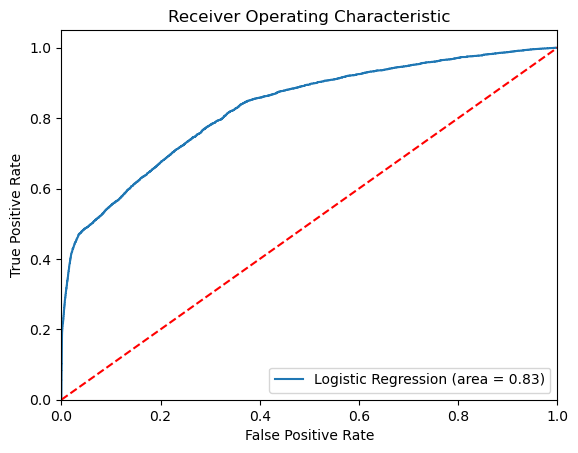

In [61]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Time Series (TO BE DONE)

In [37]:
#creating data frames
crime_agg = crime_df.groupby(by=month).size()
crime_sum = crime_df.groupby(by=month).sum()

In [38]:
#number of crimes per month
crime_agg

2022-01    15450
2022-02    15126
2022-03    18207
2022-04    17816
2022-05    19972
2022-06    20512
2022-07    22013
2022-08    21970
2022-09    21947
2022-10    22643
2022-11    16460
dtype: int64